# Self-supervised scene classification
Note that a lot of this code has been based on the practical session of the course and the [Keras documentation](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/).

I worked with Keras instead of Pytorch because it had a

In [63]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

import os
from datetime import time

from PIL import Image

In [64]:
# settings
## input
INPUT_SHAPE = (224, 224)
NUM_CLASSES = 15
## training
BATCH_SIZE = 15
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

In [65]:
OPTIMIZER = None
NUM_FULLY_CONNECTED_LAYERS = None

In [66]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [67]:
tf.config.list_physical_devices('GPU')

[]

## Load Dataset

In [69]:
data_dir = '15SceneData'
data_dir = '15SceneData_small'
ds_train = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=INPUT_SHAPE,
    shuffle=True,
    seed=42,
)

ds_validation = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'validation'),
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    class_names=ds_train.class_names,
    batch_size=BATCH_SIZE,
    image_size=INPUT_SHAPE,
    shuffle=True,
    seed=42,
)


LABELS = ds_train.class_names

Found 141 files belonging to 15 classes.
Found 317 files belonging to 15 classes.


In [70]:
LABELS = ds_train.class_names
print(LABELS)

['bedroom', 'coast', 'forest', 'highway', 'industrial', 'insidecity', 'kitchen', 'livingroom', 'mountain', 'office', 'opencountry', 'store', 'street', 'suburb', 'tallbuilding']


In [71]:
def get_label(tensor: tf.Tensor):
    global LABELS
    return LABELS[tf.argmax(tensor)]

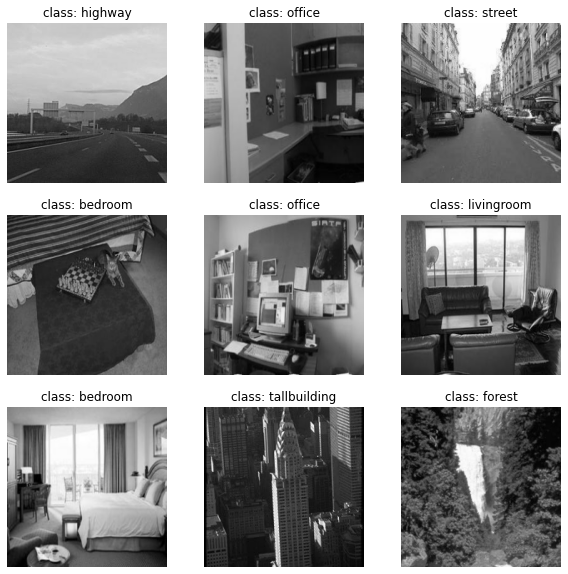

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for sample in ds_train.take(1):
    # print the first 9 images and labels of the first batch in the training dataset
    for i in range(9):
        image, label_probs = sample[0][i], sample[1][i]
        label = get_label(label_probs)

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"class: {label}")
        plt.axis("off")

## 3.1 Supervised learning scheme
In this section, you should fine-tune a convolutional neural network architecture, pretrained on the ImageNet [2] dataset, on the 15 scene dataset. In this assignment you will
use a pre-trained EfficientNet-B0 architecture. Following the exercise session on Transfer
Learning, you should make all layers in feature extraction and classifier parts of the model
trainable. The bellow address provides you with the scheme of the architecture of the
EfficientNet-B0.
https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd

In [73]:
from tensorflow.keras import layers

with strategy.scope():
    inputs = layers.Input(shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3))
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

hist = model.fit(ds_train, epochs=NUM_EPOCHS, validation_data=ds_validation, verbose=2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 15)               4068786   
                                                                 
Total params: 4,068,786
Trainable params: 4,026,763
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/10
10/10 - 44s - loss: 4.7870 - accuracy: 0.0993 - val_loss: 2.7334 - val_accuracy: 0.0694 - 44s/epoch - 4s/step
Epoch 2/10
10/10 - 21s - loss: 4.0446 - accuracy: 0.1560 - val_loss: 2.7727 - val_accuracy: 0.0789 - 21s/epoch - 2s/step
Epoch 3/10
10/10 - 21s - loss: 3.2544 - accuracy: 0.1702 - val_loss: 2.8326 - val_accuracy: 0.0694 - 21s/epoch - 2s/step
Epoch 4/10
10/10 - 21s - loss: 2.5888 - accuracy: 0.3191 - val_loss: 2.9423 -

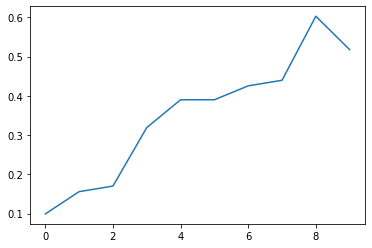

In [74]:
plt.plot(hist.history['accuracy'])

###